# Evaluate XGBoost Model for different time slices

In this experiment we want to fit an XGBoost Model only using different time slice. 

For each time slice that we have in our data set, we fit one XGBoost model. 

Then we will compare the performance of all models.

In [25]:
import pandas as pd
import seaborn as sns
import shap
from matplotlib import pyplot as plt
import monipy.utils.database as database
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### 1. Helping Functions

In [26]:
def load_and_prep_data(window=0, data_filter=4):
    # load data
    df = pd.concat([pd.read_csv(f"data/useable_yes_unknown/filter_{data_filter}/sandor_full.csv", index_col=[0]),
              pd.read_csv(f"data/useable_yes/filter_{data_filter}/ukt_full.csv", index_col=[0]),
              pd.read_csv(f"data/useable_yes/filter_{data_filter}/freiburg_full.csv", index_col=[0]),
              pd.read_csv(f"data/useable_yes/filter_{data_filter}/uka_corvolution_full.csv", index_col=[0]),
              pd.read_csv(f"data/useable_yes/filter_{data_filter}/uka_klinik_full.csv", index_col=[0]),
             ])
    
    # rename column
    df = df.rename(columns={"window_Unnamed: 2093_level_1": "window"})
    
    # filter for one starting window
    df = df[df["window"] == window]
    
    # get patient specific columns
    df_patients_columns = database.get_all_patients().columns
    
    # drop patient specific columns and other columns
    df = df.drop(columns = list(df_patients_columns))

    columns = ["seizure_id_Unnamed: 2091_level_1", 
           "record_id", "window", 
           "timestamp_start_Unnamed: 2094_level_1"]
    df = df.drop(columns=columns)

    return df

In [27]:
def train_test_val_split(df):
    # split the data val, test, train
    val_patients = pd.read_csv("data/patients/val_patients_1.csv", index_col=[0]).reset_index(drop=True)
    test_patients = pd.read_csv("data/patients/test_patients_1.csv", index_col=[0]).reset_index(drop=True)
    
    df_val = df[df["patient_id"].isin(val_patients.iloc[:, 0])].reset_index(drop=True)
    df_test = df[df["patient_id"].isin(test_patients.iloc[:, 0])].reset_index(drop=True)
    df_train = df[~(df["patient_id"].isin(set(val_patients.iloc[:, 0]) | set(test_patients.iloc[:, 0])))].reset_index(drop=True)
    return df_val, df_test, df_train

In [28]:
def create_splits(df_train, df_test, df_val, features, time_slice=0):
    data_split = {}
    for split in ["val", "test", "train"]:
        data_split[f"X_{split}"] = eval(f"df_{split}")[[f"{feature}_{time_slice}" for feature in features]]
        data_split[f"y_{split}"] = eval(f"df_{split}")[["seizure"]]
    return data_split["X_train"], data_split["y_train"], data_split["X_test"], data_split["y_test"], data_split["X_val"], data_split["y_val"]

In [29]:
# fit xgboost model
def fit_and_eval(X_train, y_train, X_test, y_test):
    # Define initial hyperparameters
    params = {
        'objective': 'binary:logistic',  # Binary classification objective
        'learning_rate': 0.1,  # Learning rate
        'max_depth': 7, # Maximum depth of each tree
        'n_estimators': 300,
        'subsample': 0.8,  # Subsample ratio of the training instances
        'colsample_bytree': 0.8,  # Subsample ratio of features when constructing each tree
        'scale_pos_weight': 0.9,
    }

    # Create the XGBoost classifier
    model = XGBClassifier(**params)

    # Train the XGBoost model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # return evaluation
    return model, (accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred), classification_report(y_test, y_pred),recall_score(y_test, y_pred),recall_score(y_test, y_pred, pos_label=0))

In [30]:
features = {'avg',
 'csi',
 'csi_filtered',
 'csi_filtered_slope',
 'csi_slope',
 'csim',
 'csim_filtered',
 'csim_filtered_slope',
 'csim_slope',
 'cvi',
 'hf',
 'hr_diff',
 'hr_diff_filtered',
 'hr_diff_filtered_slope',
 'hr_diff_slope',
 'kurt',
 'lf',
 'lf_hf_ratio',
 'mf_coef_center',
 'mf_coef_left',
 'mf_coef_right',
 'mf_hurst_max',
 'nnx',
 'pnnx',
 'quantile_25',
 'quantile_50',
 'quantile_75',
 'rmssd',
 'rmssd_dt',
 'sd',
 'sd1',
 'sd2',
 'skew',
 'total_power',
 'triangular_index',
 'ulf',
 'variance',
 'vlf'}

### 2. Load Data

In [48]:
df = load_and_prep_data()
print(df.shape)
df_val, df_test, df_train = train_test_val_split(df)

[creating new connection]
(3320, 2092)


### 3. Fit and Evaluate XGBoost models for different time slices (starting with onset)

In [49]:
# compare time_slice performance
metrics = []
for time_slice in range(55):
    X_train, y_train, X_test, y_test, X_val, y_val = create_splits(df_train, df_test, df_val, features, time_slice)
    _, evaluation = fit_and_eval(X_train, y_train, X_test, y_test)
    metrics.append(evaluation)

In [50]:
df_metrics = pd.DataFrame(metrics).sort_values(by=0, ascending=False)

In [51]:
df_metrics = df_metrics.reset_index()

In [52]:
df_metrics

,index,0,1,2,3,4
0,0,0.931873,"[[294, 2], [26, 89]]",precision recall f1-score ...,0.773913,0.993243
1,3,0.907543,"[[293, 3], [35, 80]]",precision recall f1-score ...,0.695652,0.989865
2,2,0.902676,"[[293, 3], [37, 78]]",precision recall f1-score ...,0.678261,0.989865
3,1,0.900243,"[[293, 3], [38, 77]]",precision recall f1-score ...,0.669565,0.989865
4,6,0.890511,"[[294, 2], [43, 72]]",precision recall f1-score ...,0.626087,0.993243
5,4,0.878345,"[[287, 9], [41, 74]]",precision recall f1-score ...,0.643478,0.969595
6,5,0.873479,"[[292, 4], [48, 67]]",precision recall f1-score ...,0.582609,0.986486
7,7,0.834550,"[[291, 5], [63, 52]]",precision recall f1-score ...,0.452174,0.983108
8,9,0.834550,"[[293, 3], [65, 50]]",precision recall f1-score ...,0.434783,0.989865
9,8,0.827251,"[[290, 6], [65, 50]]",precision recall f1-score ...,0.434783,0.979730


Text(0, 0.5, 'recall')

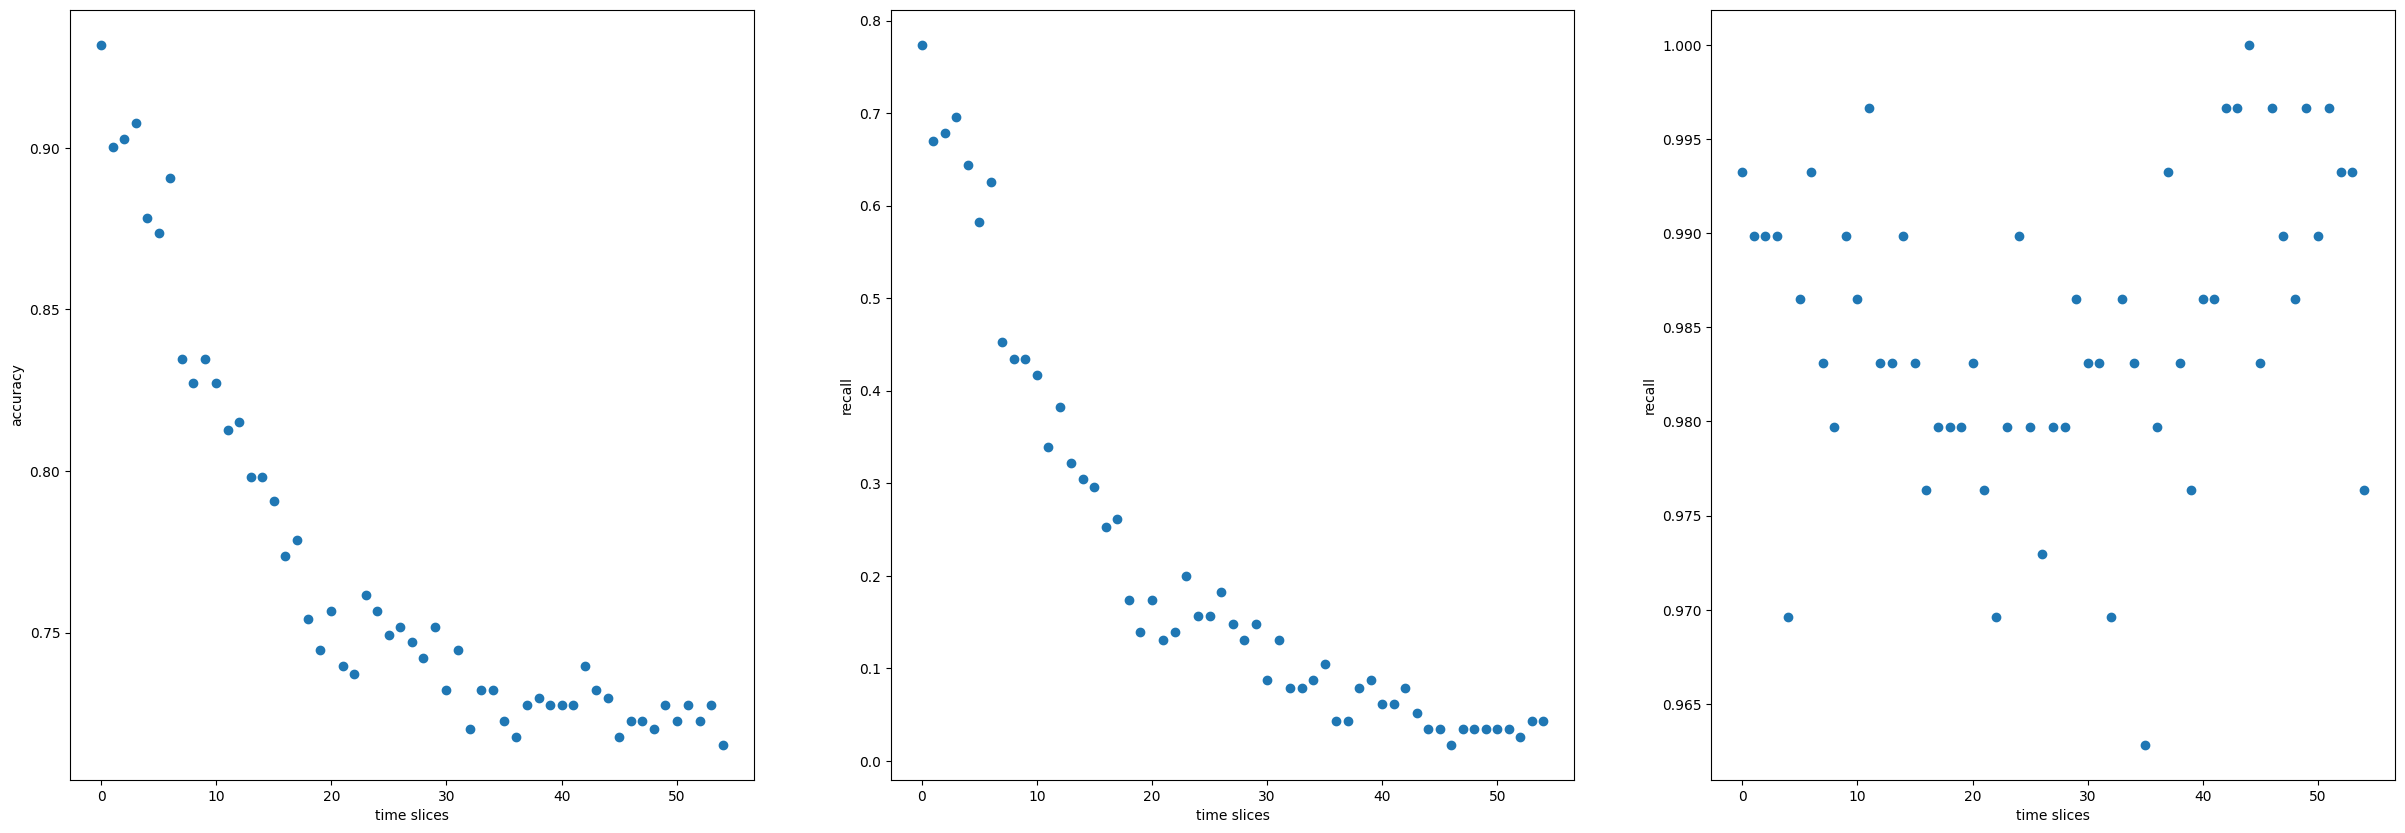

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30,10))

ax1.scatter(df_metrics["index"], df_metrics[0])
ax1.set_xlabel("time slices")
ax1.set_ylabel("accuracy")

ax2.scatter(df_metrics["index"], df_metrics[3])
ax2.set_xlabel("time slices")
ax2.set_ylabel("recall")

ax3.scatter(df_metrics["index"], df_metrics[4])
ax3.set_xlabel("time slices")
ax3.set_ylabel("recall")

### 4. Fit and Evaluate XGBoost models for different time slices (90 seconds prior to onset)

In [37]:
# load data
df = load_and_prep_data(window=-18)

[creating new connection]


In [38]:
df_val, df_test, df_train = train_test_val_split(df)

In [39]:
# compare time_slice performance
metrics_2 = []
for time_slice in range(55):
    X_train, y_train, X_test, y_test, X_val, y_val = create_splits(df_train, df_test, df_val, features, time_slice)
    _, evaluation = fit_and_eval(X_train, y_train, X_test, y_test)
    metrics_2.append(evaluation)

In [40]:
df_metrics_2 = pd.DataFrame(metrics_2).sort_values(by=0, ascending=False)

In [41]:
df_metrics_2

,0,1,2,3,4
14,0.948905,"[[294, 2], [19, 96]]",precision recall f1-score ...,0.834783,0.993243
16,0.941606,"[[294, 2], [22, 93]]",precision recall f1-score ...,0.808696,0.993243
15,0.941606,"[[293, 3], [21, 94]]",precision recall f1-score ...,0.817391,0.989865
13,0.939173,"[[291, 5], [20, 95]]",precision recall f1-score ...,0.826087,0.983108
18,0.934307,"[[294, 2], [25, 90]]",precision recall f1-score ...,0.782609,0.993243
20,0.931873,"[[292, 4], [24, 91]]",precision recall f1-score ...,0.791304,0.986486
17,0.931873,"[[293, 3], [25, 90]]",precision recall f1-score ...,0.782609,0.989865
19,0.927007,"[[292, 4], [26, 89]]",precision recall f1-score ...,0.773913,0.986486
9,0.924574,"[[293, 3], [28, 87]]",precision recall f1-score ...,0.756522,0.989865
7,0.922141,"[[293, 3], [29, 86]]",precision recall f1-score ...,0.747826,0.989865


Text(0, 0.5, 'recall')

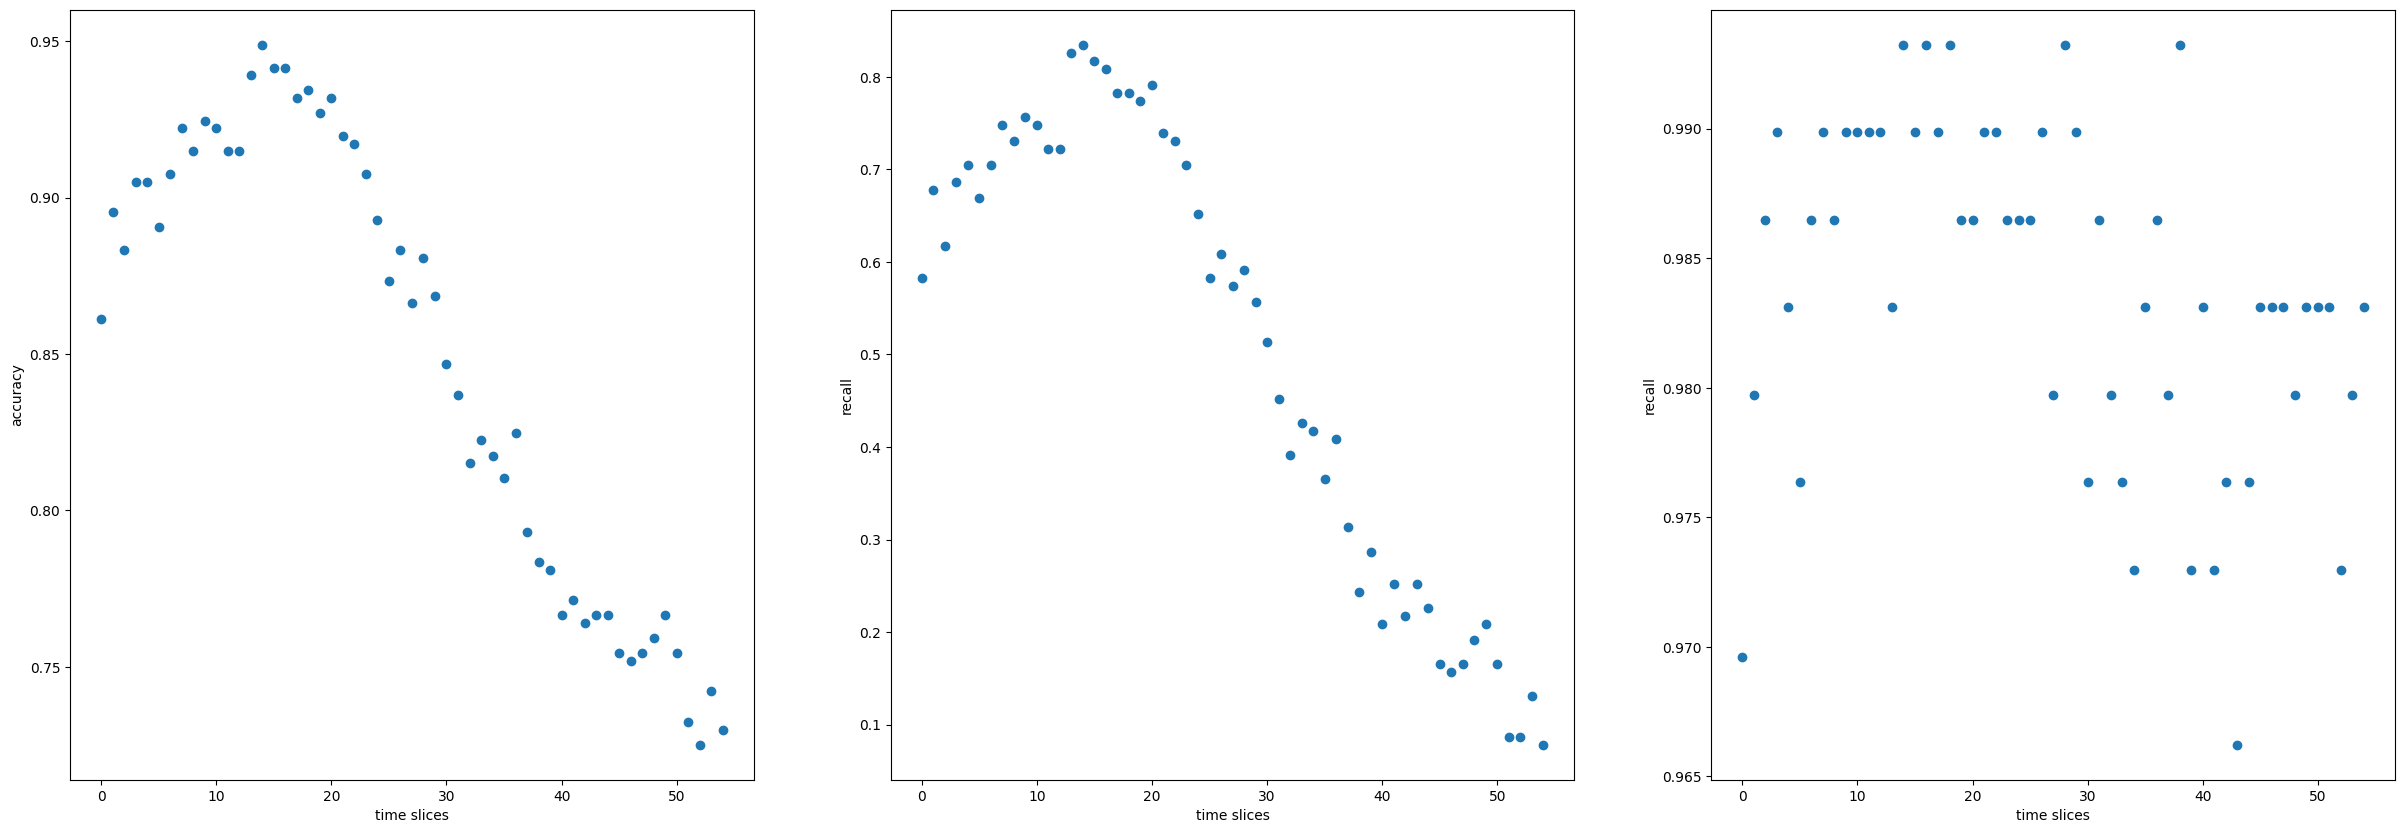

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30,10))

ax1.scatter(df_metrics_2.index, df_metrics_2[0])
ax1.set_xlabel("time slices")
ax1.set_ylabel("accuracy")

ax2.scatter(df_metrics_2.index, df_metrics_2[3])
ax2.set_xlabel("time slices")
ax2.set_ylabel("recall")

ax3.scatter(df_metrics_2.index, df_metrics_2[4])
ax3.set_xlabel("time slices")
ax3.set_ylabel("recall")

#fig.savefig("metrics_18.png")